In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [25]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Attention, Add, BatchNormalization, Lambda, Activation, Multiply, Dense, Flatten, Input, Concatenate, concatenate, UpSampling2D, LayerNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Conv2DTranspose
from tensorflow import keras
from utils import add_white_gaussian_noise, somar_sinais

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import stft, istft
import librosa
from datetime import datetime

In [3]:
from sound import Sound

In [4]:
base_shape_size = 8192
ws = 255
ol = 128
NORM_FACTOR = 128

In [5]:
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 210.71it/s]


In [6]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [7]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []

            xA_batch = []
            xphi_batch = []
            yA_batch = []
            yphi_batch = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                min_valor = np.min(sound)
                max_valor = np.max(sound)
                
                # Defina o novo intervalo desejado
                novo_min = -0.4
                novo_max = 0.4
                
                # Realize a escala do sinal para o novo intervalo
                sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min

                sr = np.random.randint(0, 20, size=(1,)[0])
                noisy_sound = somar_sinais(sound_escalado, noise, sr)
                
                # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                
                A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)

                # A /= NORM_FACTOR
                # A_noisy /= NORM_FACTOR

                # A = 10*np.log10(A)
                # A_noisy = 10*np.log10(A_noisy)

                # xA_batch.append(A)
                # xphi_batch.append(phi)
                # yA_batch.append(A_noisy)
                # yphi_batch.append(phi_noisy)
                
                # Monta o fasor normalizando a faze por Pi
                F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(F_noisy)
                y_train.append(F)

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            
            yield x_train, y_train

In [8]:
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [9]:
def unet(inputs):
    # Codificador
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = BatchNormalization()(pool2)
    
    # Camada central
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    
    # Decodificador
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    
    # Camada de saída
    output = Conv2D(2, 3, activation='linear', padding='same')(conv5)

    return output

In [10]:
def unet2(inputs):
    # Codificador
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = BatchNormalization()(pool2)
    

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Camada central
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decodificador
    up1 = UpSampling2D(size=(2, 2))(conv6)
    up1 = Conv2D(512, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv4, up1], axis=3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(merge1)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    up2 = Conv2D(256, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv3, up2], axis=3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same')(merge2)

    up3 = UpSampling2D(size=(2, 2))(conv8)
    up3 = Conv2D(128, 2, activation='relu', padding='same')(up3)
    merge3 = concatenate([conv2, up3], axis=3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same')(merge3)
    
    up4 = UpSampling2D(size=(2, 2))(conv9)
    up4 = Conv2D(64, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv1, up4], axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(merge4)
    
    # Camada de saída
    output = Conv2D(2, 3, activation='relu', padding='same')(conv10)
    output = Conv2D(2, 3, activation='relu', padding='same')(output)

    return output

In [11]:
def unet_with_attention(inputs):
    # Codificador
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)  # Shape esperado: (128, 64, 64)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Shape esperado: (64, 32, 64)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)  # Shape esperado: (64, 32, 128)
    # attention1 = Attention()([conv2, pool1])  # Adiciona uma camada de atenção
    # Shape esperado após a atenção: (64, 32, 128)
    # merged1 = concatenate([conv2, attention1], axis=3)  # Shape esperado: (64, 32, 256)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Shape esperado: (32, 16, 256)
    pool2 = BatchNormalization()(pool2)  # Shape não é alterado

    # Camada central
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)  # Shape esperado: (32, 16, 256)

    # Decodificador
    up4 = UpSampling2D(size=(2, 2))(conv3)  # Shape esperado: (64, 32, 256)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)  # Shape esperado: (64, 32, 128)
    attention2 = Attention()([up4, conv2])  # Adiciona uma camada de atenção
    # Shape esperado após a atenção: (64, 32, 128)
    merged2 = concatenate([up4, attention2], axis=3)  # Shape esperado: (64, 32, 256)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merged2)  # Shape esperado: (64, 32, 128)

    up5 = UpSampling2D(size=(2, 2))(conv4)  # Shape esperado: (128, 64, 128)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)  # Shape esperado: (128, 64, 64)
    attention3 = Attention()([up5, conv1])  # Adiciona uma camada de atenção
    # Shape esperado após a atenção: (128, 64, 64)
    merged3 = concatenate([up5, attention3], axis=3)  # Shape esperado: (128, 64, 128)

    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merged3)  # Shape esperado: (128, 64, 64)

    # Camada de saída
    output = Conv2D(2, 3, activation='relu', padding='same')(conv5)  # Shape esperado: (128, 64, 2)

    return output

In [12]:
# Defina uma função para criar uma U-Net simplificada
def create_unet(inputs, type='mag'):
    # Codificador
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)
    
    # Camada central
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    
    # Decodificador
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)

    if type == 'mag':
        # Camada de classificação por pixel
        outputs = keras.layers.Conv2D(1, 3, activation="relu", padding="same")(conv5)
    if type == 'phase':
        # Camada de classificação por pixel
        outputs = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(conv5)

    return outputs

def get_model(inputs):
    # Separe os canais de entrada
    channel1 = inputs[..., 0:1]
    channel2 = inputs[..., 1:2]

    # Crie U-Nets separadas para cada canal
    output_channel1 = create_unet(channel1)
    output_channel2 = create_unet(channel2, type='phase')

    # Concatene os resultados de volta em um tensor de forma (128, 64, 2)
    outputs = keras.layers.Concatenate()([output_channel1, output_channel2])
    
    return outputs

In [13]:
inputs = Input((128, 64, 2))
outputs = unet(inputs)
# outputs = unet2(inputs)
# outputs = get_model(inputs)
# outputs = unet_with_attention(inputs)
# outputs = res_unet(inputs)
model = Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  1216        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 128)  73856       ['max_pooling2d[0][0]']      

In [15]:
model.compile(optimizer='adam', loss='msle')

In [24]:
batch_size = 128
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                    )

Starting training
Epoch 1
47/47 [==============================] - 16s 340ms/step - loss: 0.0200 - val_loss: 0.0203
Epoch 2
47/47 [==============================] - 16s 340ms/step - loss: 0.0201 - val_loss: 0.0189
Epoch 3
47/47 [==============================] - 16s 340ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 4
47/47 [==============================] - 16s 340ms/step - loss: 0.0197 - val_loss: 0.0195
Epoch 5
47/47 [==============================] - 16s 340ms/step - loss: 0.0197 - val_loss: 0.0203
Epoch 6
47/47 [==============================] - 16s 341ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 7
47/47 [==============================] - 16s 341ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 8
47/47 [==============================] - 16s 340ms/step - loss: 0.0196 - val_loss: 0.0199
Epoch 9
47/47 [==============================] - 16s 340ms/step - loss: 0.0197 - val_loss: 0.0202
Epoch 10
47/47 [==============================] - 16s 340ms/step - loss: 0.0198 - val_loss: 0.0194


In [26]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

model.save('unet-STFT-20-epochs-'+datetime_str+'.h5')

## Teste do modelo treinado

In [27]:
x_test, y_test = next(data_generator_val.generate_sample_completo(batch_size=1))

In [28]:
print(np.max(x_test[:, :, : , 0]))
print(np.min(x_test[:, :, : , 0]))
print(np.max(y_test[:, :, : , 0]))
print(np.min(y_test[:, :, : , 0]))

10.153409
0.00072963716
10.165778
0.00017132625


In [29]:
F_f = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


In [30]:
print(np.max(F_f))
print(np.min(F_f))
print(F_f.shape)

9.92414
-0.020653926
(1, 128, 64, 2)


In [31]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

In [32]:
print(np.max(A_f))
print(np.max(phi_f))
print(np.min(A_f))
print(np.min(phi_f))

9.92414
3.6169598
-0.020653926
-3.176124


/tmp/ipykernel_31/3224369657.py:18: RuntimeWarning: invalid value encountered in log10
  im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')


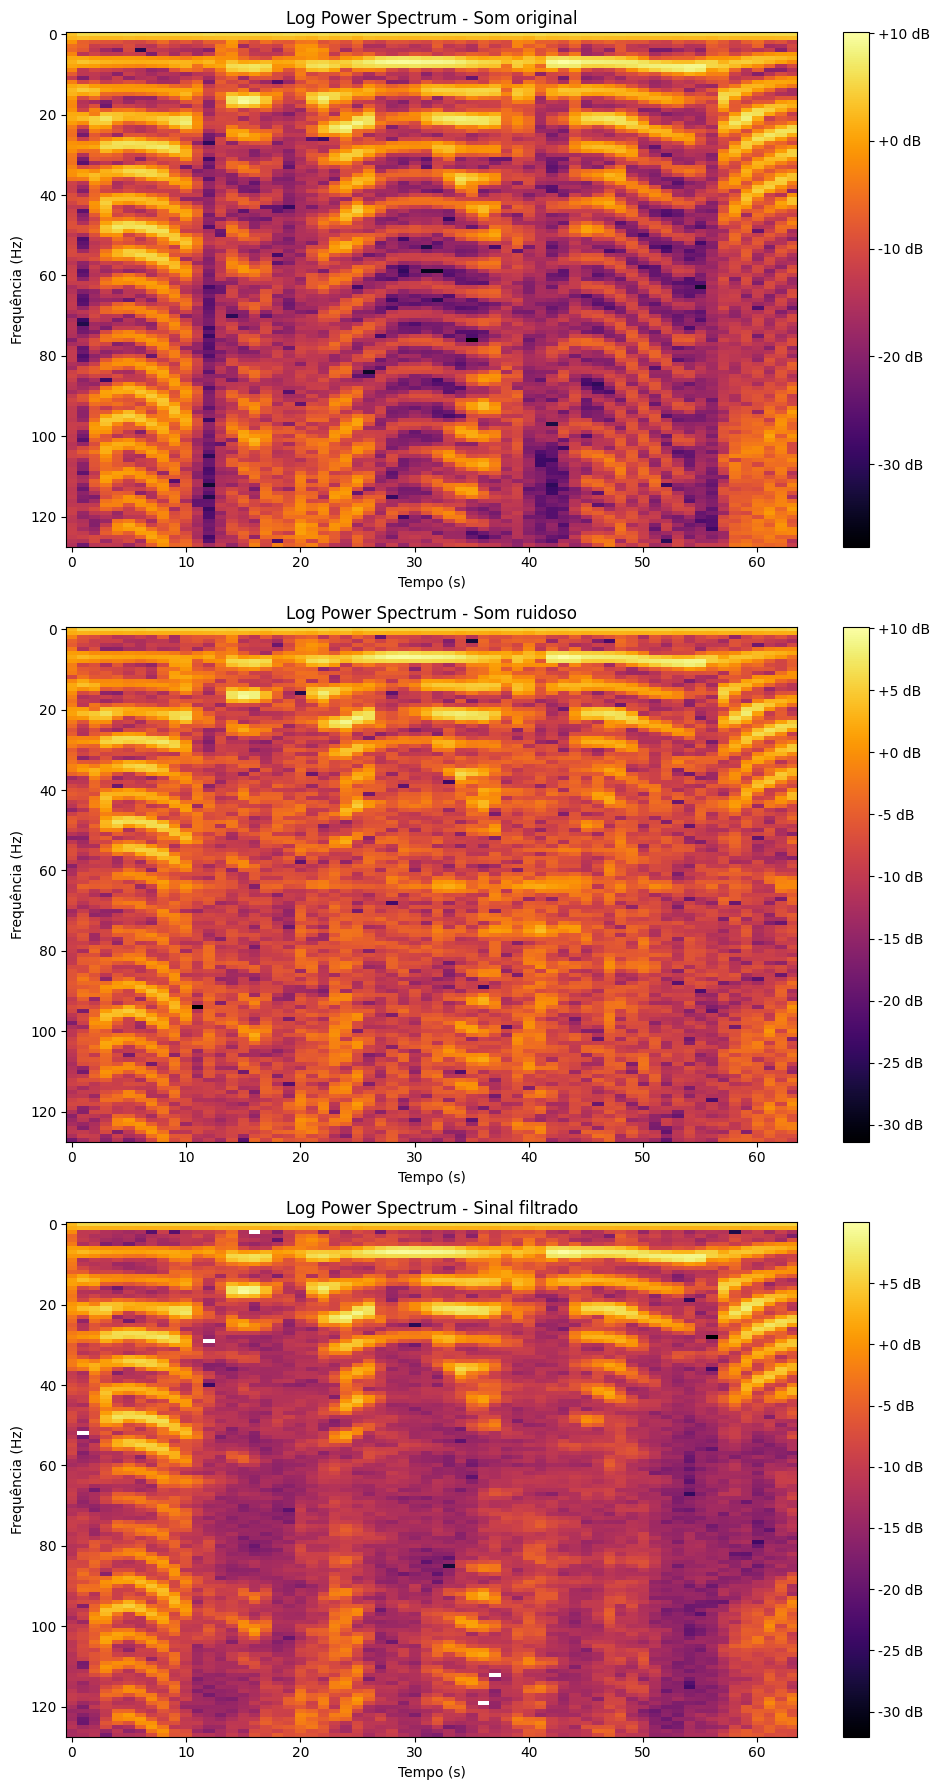

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Primeiro gráfico
im = axs[0].imshow(10*np.log10(A), aspect='auto', cmap='inferno')
axs[0].set_title('Log Power Spectrum - Som original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[0], format='%+2.0f dB')

# Segundo gráfico
im = axs[1].imshow(10*np.log10(A_n), aspect='auto', cmap='inferno')
axs[1].set_title('Log Power Spectrum - Som ruidoso')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[1], format='%+2.0f dB')

# Terceiro gráfico
im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')
axs[2].set_title('Log Power Spectrum - Sinal filtrado')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[2], format='%+2.0f dB')

plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
plt.show()

In [34]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

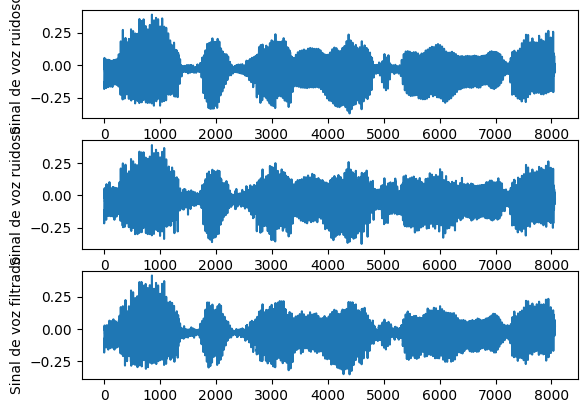

In [35]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [36]:
Audio(data=s, rate=8000)

In [37]:
Audio(data=s_n, rate=8000)

In [38]:
Audio(data=s_f, rate=8000)

In [39]:
!pwd

/tf/_old
